In [1]:
import numpy as np
import gymnasium as gym
from dataclasses import dataclass
import typing as tt
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
HIDDEN_SIZE = 128
BATCH_SIZE = 16
PERCENTILE = 70

In [4]:
class DiscreteOneHotWrapper(gym.ObservationWrapper):
    def __init__(self, env: gym.Env):
        super(DiscreteOneHotWrapper, self).__init__(env)
        assert isinstance(env.observation_space, gym.spaces.Discrete)
        shape = (env.observation_space.n, )
        self.observation_space = gym.spaces.Box(0.0, 1.0, shape, dtype=np.float32)

    def observation(self, observation):
        res = np.copy(self.observation_space.low)
        res[observation] = 1.0
        return res

In [5]:
class Net(nn.Module):
    def __init__(self, obs_size: int, hidden_size: int,
                 n_actions: int):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [6]:
@dataclass
class EpisodeStep:
    observation: np.ndarray
    action: int

@dataclass
class Episode:
    reward: float
    steps: tt.List[EpisodeStep]

In [7]:
def iterate_batches(env: gym.Env, net: Net, batch_size: int) -> \
        tt.Generator[tt.List[Episode], None, None]:
    batch = []
    episode_reward = 0.0
    episode_steps = []
    obs, _ = env.reset()
    sm = nn.Softmax(dim=1)
    while True:
        obs_v = torch.tensor(obs, dtype=torch.float32)
        act_probs_v = sm(net(obs_v.unsqueeze(0)))
        act_probs = act_probs_v.data.numpy()[0]
        action = np.random.choice(len(act_probs), p=act_probs)
        next_obs, reward, is_done, is_trunc, _ = env.step(action)
        episode_reward += float(reward)
        step = EpisodeStep(observation=obs, action=action)
        episode_steps.append(step)
        if is_done or is_trunc:
            e = Episode(reward=episode_reward, steps=episode_steps)
            batch.append(e)
            episode_reward = 0.0
            episode_steps = []
            next_obs, _ = env.reset()
            if len(batch) == batch_size:
                yield batch
                batch = []
        obs = next_obs

In [8]:
def filter_batch(batch: tt.List[Episode], percentile: float) -> \
        tt.Tuple[torch.FloatTensor, torch.LongTensor, float, float]:
    rewards = list(map(lambda s: s.reward, batch))
    reward_bound = float(np.percentile(rewards, percentile))
    reward_mean = float(np.mean(rewards))

    train_obs: tt.List[np.ndarray] = []
    train_act: tt.List[int] = []
    for episode in batch:
        if episode.reward < reward_bound:
            continue
        train_obs.extend(map(lambda step: step.observation,
                             episode.steps))
        train_act.extend(map(lambda step: step.action,
                             episode.steps))

    train_obs_v = torch.FloatTensor(np.vstack(train_obs))
    train_act_v = torch.LongTensor(train_act)
    return train_obs_v, train_act_v, reward_bound, reward_mean

In [9]:
env = DiscreteOneHotWrapper(gym.make("FrozenLake-v1"))
obs_size = env.observation_space.shape[0]
n_actions = int(env.action_space.n)

net = Net(obs_size, HIDDEN_SIZE, n_actions)
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.01)

losses = []
reward_means = []
reward_bounds = []

for iter_no, batch in enumerate(iterate_batches(env, net, BATCH_SIZE)):
    obs_v, acts_v, reward_b, reward_m = filter_batch(batch, PERCENTILE)
    optimizer.zero_grad()
    action_scores_v = net(obs_v)
    loss_v = objective(action_scores_v, acts_v)
    loss_v.backward()
    optimizer.step()
    print("%d: loss=%.3f, reward_mean=%.1f, reward_bound=%.1f" % (
        iter_no, loss_v.item(), reward_m, reward_b))
    
    losses.append(loss_v.item())
    reward_means.append(reward_m)
    reward_bounds.append(reward_b)
    
    if reward_m > 0.8 or iter_no > 1000:
        print("Solved!")
        break

0: loss=1.383, reward_mean=0.0, reward_bound=0.0
1: loss=1.377, reward_mean=0.0, reward_bound=0.0
2: loss=1.370, reward_mean=0.0, reward_bound=0.0
3: loss=1.366, reward_mean=0.1, reward_bound=0.0
4: loss=1.345, reward_mean=0.0, reward_bound=0.0
5: loss=1.351, reward_mean=0.0, reward_bound=0.0
6: loss=1.285, reward_mean=0.0, reward_bound=0.0
7: loss=1.263, reward_mean=0.0, reward_bound=0.0
8: loss=1.295, reward_mean=0.0, reward_bound=0.0
9: loss=1.233, reward_mean=0.0, reward_bound=0.0
10: loss=1.131, reward_mean=0.0, reward_bound=0.0
11: loss=1.171, reward_mean=0.0, reward_bound=0.0
12: loss=1.092, reward_mean=0.0, reward_bound=0.0
13: loss=1.087, reward_mean=0.0, reward_bound=0.0
14: loss=1.079, reward_mean=0.0, reward_bound=0.0
15: loss=1.041, reward_mean=0.0, reward_bound=0.0
16: loss=1.052, reward_mean=0.0, reward_bound=0.0
17: loss=0.963, reward_mean=0.0, reward_bound=0.0
18: loss=1.043, reward_mean=0.0, reward_bound=0.0
19: loss=0.963, reward_mean=0.0, reward_bound=0.0
20: loss=0

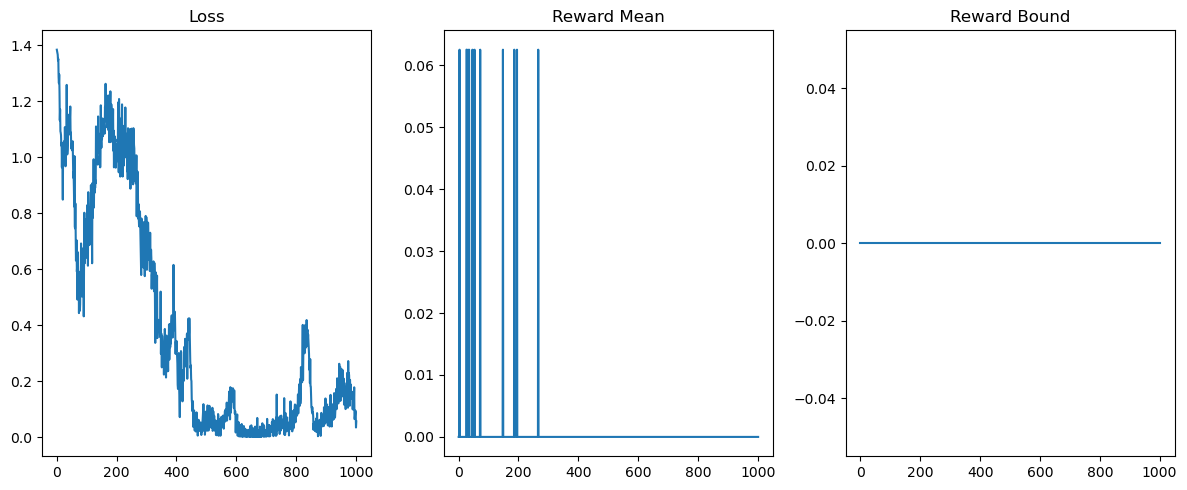

In [10]:
# Plotting the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(losses)
plt.title('Loss')

plt.subplot(1, 3, 2)
plt.plot(reward_means)
plt.title('Reward Mean')

plt.subplot(1, 3, 3)
plt.plot(reward_bounds)
plt.title('Reward Bound')

plt.tight_layout()
plt.show()